In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from importlib import reload
from agents import Agent
from tasks import akam_tasks as ts
import config as co
from utils import *  # get_current_file_name, goto_root_dir
import pprint
import joblib
from path_settings import *
import CustomMapper.CustomMapper as c
import torch
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from agents.DynamicSystems import ISNNet
from agents.ComplexAgent import DynamicAgent
import copy
import plotly.express as px


reload(ts)
pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()

2025-08-12 17:29:47.111709: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 17:29:47.120146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-12 17:29:47.132731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-12 17:29:47.132755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-12 17:29:47.141973: I tensorflow/core/platform/cpu_feature_gua

In [3]:
agent = "MB0s"
try: 
    experiment = pickle.load(open(DATA_PATH/f"experiment_{agent}_1.pkl", "rb"))
    experiment.initialise_dataloaders()
    experiment.configs["model_specs"]["model_params"]["batch_size"] = 64
    experiment.initialise_trainer(experiment.configs)
except FileNotFoundError:
    print(f"Experiment for {agent} not found. Please run the simulation first.")
    tasks = {
        # "PRL": ts.Two_step(com_prob=1),  # common transition always happens
        # "RTS": ts.Two_step(),
        # "NTS": ts.Two_step(rew_gen="trans_rev"),
        "walk": ts.Two_step(rew_gen="walks"),
    }
    N_blocks = 1000
    N_trials = 100
    device = "cpu"
    exp_folder = 0  #automatically generate this
    seed = 0
    # For now only consider RTS
    agents = {}
    config = {}
    cog_types = ["MB0s", "LS0", "MB0", "MB1"]

    for cog_type in cog_types:
        cog_config = co.sim_config_from_inputs(False, 
                                            agent_type="RTSCog", 
                                            cog_type=cog_type, 
                                            device=device, 
                                            seed=seed,
                                            num_blocks=N_blocks,
                                            num_trials=N_trials,
                                            exp_folder=0)
        config[f'walks_{cog_type}'] = cog_config
        agents[f'walks_{cog_type}'] = Agent(cog_config['agent_type'], config = cog_config)

    for cog_type in cog_types: 
        agents[f'walks_{cog_type}'].simulate(tasks["walk"], config[f'walks_{cog_type}'], save = True)
        
    # Trainer parameters
    batch_size = 20
    RTRNN_config = {
        "task": "PRL_Bartolo", 
        "dt": 0.02, # 0.02s time step, as in Jaffe et al. 
        "T": 200, # 1s upper for RT
        "n_blocks": 800,
        "cog_data": SIM_SAVE_PATH / 'simulated_Akam_RTS' / 'LS0_seed0.pkl',
        "bias": 0.01, 
        "ndt_s": 0.01, 
        "ndt_mu": 0.1, 
        "driftscale": 2, 
        "redo_choices": False,
        "trainer_type": "RTRNNTrainer",
        "model_specs": {
            "model_name": "RTRNN", 
            "model_path": "Network_models.RTRNN",
            "model_params":{
                "batch_size": batch_size, "input_size": 6, "output_size": 2, "hidden_size": 16, "recurrence_per_trial": 2,
                "cell_type":"GRU", "trial_output_hidden": 0, "trial_output_hidden_size": [], # if want hidden output layers (deep output, then give a list)
                "trial_output_hidden_nonlinearities": [], "pad_zeros":0, "last_step": False
            },
        },
        "rt_weight": 0.01,
        "device": "cuda", 
        "scheduler": {
            "name": "ReduceLROnPlateau",
            "params": {
                "mode": "min",
                "factor": 0.1,
                "patience": 100,
                "min_lr": 5e-4,
                "cooldown": 50, 
            },
        }, 
        "optimizer_specs":{
            "optimizer_name": "Adam",
            "optimizer_params": {
                "lr": 0.0005,
            },
        },
        "training_config":{
            "task_id": "1.1",
            "task_config": {
                "task": "PRL_Bartolo",
            }
        },  
        "save_path": MODEL_SAVE_PATH ,
        "check_path": MODEL_SAVE_PATH,
        "log_path": LOG_PATH, # These are to be modified when the big configs gets defined
    }

    for agent in ["MB0s", "LS0", "MB0", "MB1"]:
        RTRNN_config["cog_data"] = SIM_SAVE_PATH / 'simulated_Akam_RTS' / f'{agent}_seed0.pkl'
        experiment = c.CustomMapper(RTRNN_config)
        experiment.rt_model = "RELOAD"
        pickle.dump(experiment, open(DATA_PATH/f"experiment_{agent}_1.pkl", "wb"))

dataloaders = None

In [4]:
if dataloaders is None:
    dataloaders = experiment.dataloaders
    del experiment

print(f"Loaded dataloaders for {agent} agent.")

Loaded dataloaders for MB0s agent.


In [5]:
from Network_models.Trainer import SlowFastTrainer
# RTRNN training on the data!
batch_size = 128
steps = 10
identity_proj = False
configs = {
    "save_path": MODEL_SAVE_PATH / "slow_fast",
    "check_path": MODEL_SAVE_PATH / "slow_fast",
    "log_path": LOG_PATH / "slow_fast",
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.001,
        },
    },
    "model_specs":{
        "model_name": "RTSlowFastRNN", 
        "model_path": "Network_models.RTRNN",
        "model_params":{
            "input_size": 6, "n_classes": 2, "h_slow_dim": 16, "h_fast_dim": 16, "fast_steps": steps, "identity_proj": identity_proj,
            "trial_output_hidden": 1, "trial_output_hidden_size": [16,], # if want hidden output layers (deep output, then give a list)
            "trial_output_hidden_nonlinearities": ["ReLU"], "external_sum_evidence": True, 
        },
    },
    "SFloss_specs": {
        "rt_weight": 0.5,  # weight for the RT loss
    }, 

    "device": "cuda", 
    # "scheduler": False, 
    "scheduler": {
        "name": "ReduceLROnPlateau",
        "params": {
            "mode": "min",
            "factor": 0.1,
            "patience": 100,
            "min_lr": 5e-4,
            "cooldown": 50, 
        },
    }, 
    "training_config": {
        "batch_size": 256, 
        "val_ratio": 0.2, 
        "n_trials": 10, 
    }, 
}

# make the dirs
for path in [configs["save_path"], configs["check_path"], configs["log_path"]]:
    Path(path).mkdir(parents=True, exist_ok=True)
rtrnn_trainer = SlowFastTrainer(configs)
statedict=torch.load("slow_fast_archive.pth")
w_ih_l0=statedict['model_state_dict']["rnn_slow.weight_ih_l0"]
b_ih_l0=statedict['model_state_dict']["rnn_slow.bias_ih_l0"]
w_hh_l0=statedict['model_state_dict']["rnn_slow.weight_hh_l0"]
b_hh_l0=statedict['model_state_dict']["rnn_slow.bias_hh_l0"]

sch_0_b = statedict['model_state_dict']["slow_choice_head.0.bias"]
sch_0_w = statedict['model_state_dict']["slow_choice_head.0.weight"]
sch_1_b = statedict['model_state_dict']["slow_choice_head.1.bias"]
sch_1_w = statedict['model_state_dict']["slow_choice_head.1.weight"]

rtrnn_trainer.model.rnn_slow.weight_ih_l0.data.copy_(w_ih_l0)
rtrnn_trainer.model.rnn_slow.bias_ih_l0.data.copy_(b_ih_l0)
rtrnn_trainer.model.rnn_slow.weight_hh_l0.data.copy_(w_hh_l0)
rtrnn_trainer.model.rnn_slow.bias_hh_l0.data.copy_(b_hh_l0)

rtrnn_trainer.model.slow_choice_head[0].bias.data.copy_(sch_0_b)
rtrnn_trainer.model.slow_choice_head[0].weight.data.copy_(sch_0_w)
rtrnn_trainer.model.slow_choice_head[1].bias.data.copy_(sch_1_b)
rtrnn_trainer.model.slow_choice_head[1].weight.data.copy_(sch_1_w)
rtrnn_trainer.model.to("cuda")

RTSlowFastRNN(
  (rnn_slow): GRU(6, 16, batch_first=True)
  (project_sf): Linear(in_features=16, out_features=16, bias=True)
  (rnn_fast): GRU(1, 16, batch_first=True)
  (initial_evidence): Linear(in_features=16, out_features=1, bias=False)
  (evidence_head): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=False)
  )
  (fast_choice_head): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
  (slow_choice_head): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [6]:

dataloaders = {
    "train": torch.utils.data.DataLoader(
        dataloaders["train"].dataset,batch_size = batch_size, shuffle=True,)
        
    , "val": torch.utils.data.DataLoader(
        dataloaders["val"].dataset, batch_size = batch_size, shuffle=False,
        )
    }
for split in ["train", "val"]:
    dataset = dataloaders[split].dataset
    x = dataset.x
    mask = (x[..., 1] == -1)
    x[..., 1][mask] = torch.nan
    # dataloaders[split].dataset.x = x


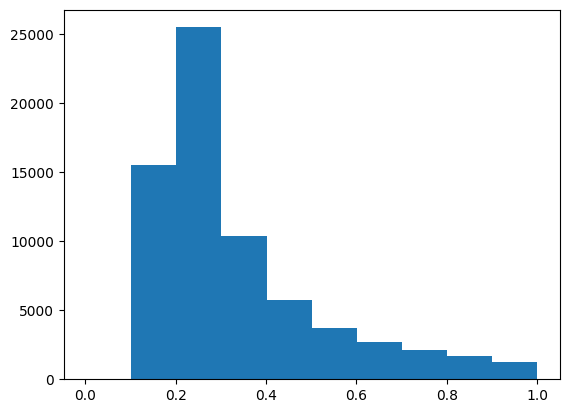

In [14]:
_ = plt.hist(dataloaders['train'].dataset.x[..., 1].cpu().numpy().flatten())

(array([2807.,    0.,    0., 9257.,    0.,    0., 5067.,    0.,    0.,
        2869.]),
 array([0.15000001, 0.19500001, 0.24000001, 0.28500003, 0.33000001,
        0.375     , 0.42000002, 0.46500003, 0.50999999, 0.55500001,
        0.60000002]),
 <BarContainer object of 10 artists>)

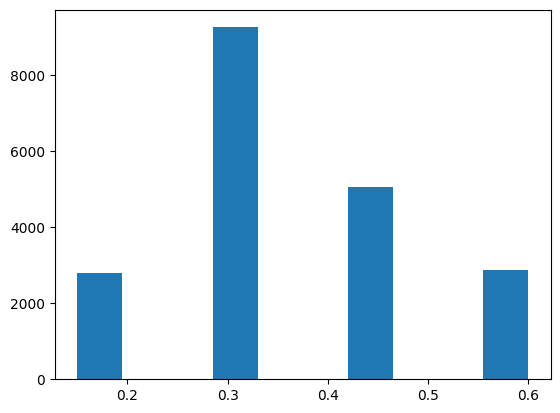

In [17]:
plt.hist(model_out['rt'].detach().cpu().numpy().flatten())

In [12]:
rtrnn_trainer.train_loop(dataloaders["train"], dataloaders["val"], stage = 0, epochs = 200)

Epoch 0 - Step 0 - train loss: 0.7105 | choice loss: 0.7105 | rt loss: 0.0000
Epoch 0 - Step 1 - train loss: 0.7117 | choice loss: 0.7117 | rt loss: 0.0000
Epoch 0 - Step 2 - train loss: 0.6989 | choice loss: 0.6989 | rt loss: 0.0000
Epoch 0 - Step 3 - train loss: 0.7002 | choice loss: 0.7002 | rt loss: 0.0000
Epoch 0 - Step 4 - train loss: 0.6935 | choice loss: 0.6935 | rt loss: 0.0000
Epoch 0 - Step 5 - train loss: 0.6973 | choice loss: 0.6973 | rt loss: 0.0000
Epoch 0 - Step 6 - train loss: 0.6898 | choice loss: 0.6898 | rt loss: 0.0000
Epoch 0 - val loss: 0.6851 | best: 0.6851
Epoch 1 - Step 0 - train loss: 0.6868 | choice loss: 0.6868 | rt loss: 0.0000
Epoch 1 - Step 1 - train loss: 0.6843 | choice loss: 0.6843 | rt loss: 0.0000
Epoch 1 - Step 2 - train loss: 0.6825 | choice loss: 0.6825 | rt loss: 0.0000
Epoch 1 - Step 3 - train loss: 0.6778 | choice loss: 0.6778 | rt loss: 0.0000
Epoch 1 - Step 4 - train loss: 0.6761 | choice loss: 0.6761 | rt loss: 0.0000
Epoch 1 - Step 5 - tra

In [30]:
rtrnn_trainer.model.freeze_slow()
rtrnn_trainer.train_loop(dataloaders["train"], dataloaders["val"], stage = 1, epochs = 200)

Epoch 0 - Step 0 - train loss: 0.6941 | choice loss: 0.3251 | rt loss: 0.7379
Epoch 0 - Step 1 - train loss: 0.5982 | choice loss: 0.3253 | rt loss: 0.5457
Epoch 0 - Step 2 - train loss: 0.5051 | choice loss: 0.3213 | rt loss: 0.3676
Epoch 0 - Step 3 - train loss: 0.4630 | choice loss: 0.3387 | rt loss: 0.2487
Epoch 0 - Step 4 - train loss: 0.4282 | choice loss: 0.3240 | rt loss: 0.2084
Epoch 0 - Step 5 - train loss: 0.4075 | choice loss: 0.3279 | rt loss: 0.1591
Epoch 0 - Step 6 - train loss: 0.3807 | choice loss: 0.2932 | rt loss: 0.1749
Epoch 0 - val loss: 0.4095 | best: 0.4095
Epoch 1 - Step 0 - train loss: 0.4299 | choice loss: 0.3312 | rt loss: 0.1974
Epoch 1 - Step 1 - train loss: 0.4263 | choice loss: 0.3191 | rt loss: 0.2144
Epoch 1 - Step 2 - train loss: 0.4353 | choice loss: 0.3258 | rt loss: 0.2191
Epoch 1 - Step 3 - train loss: 0.4342 | choice loss: 0.3272 | rt loss: 0.2139
Epoch 1 - Step 4 - train loss: 0.4293 | choice loss: 0.3119 | rt loss: 0.2349
Epoch 1 - Step 5 - tra

In [43]:
rtrnn_trainer.save_checkpoint(
    f"slow_fast_rtrnn_ckp_stage1.pt", 199, 0.3387)

In [131]:
rtrnn_trainer.load_checkpoint(
    f"slow_fast_rtrnn_ckp_stage1.pt")

In [44]:
rtrnn_trainer.model.unfreeze_slow()
rtrnn_trainer.train_loop(dataloaders["train"], dataloaders["val"], stage = 1, epochs = 200)

Epoch 0 - Step 0 - train loss: 0.3430 | choice loss: 0.3216 | rt loss: 0.0429
Epoch 0 - Step 1 - train loss: 0.3577 | choice loss: 0.3353 | rt loss: 0.0447
Epoch 0 - Step 2 - train loss: 0.3483 | choice loss: 0.3275 | rt loss: 0.0415
Epoch 0 - Step 3 - train loss: 0.3547 | choice loss: 0.3340 | rt loss: 0.0414
Epoch 0 - Step 4 - train loss: 0.3480 | choice loss: 0.3273 | rt loss: 0.0414
Epoch 0 - Step 5 - train loss: 0.3316 | choice loss: 0.3113 | rt loss: 0.0407
Epoch 0 - Step 6 - train loss: 0.3423 | choice loss: 0.3219 | rt loss: 0.0408
Epoch 0 - val loss: 0.3381 | best: 0.3381
Epoch 1 - Step 0 - train loss: 0.3525 | choice loss: 0.3328 | rt loss: 0.0393
Epoch 1 - Step 1 - train loss: 0.3528 | choice loss: 0.3331 | rt loss: 0.0395
Epoch 1 - Step 2 - train loss: 0.3374 | choice loss: 0.3184 | rt loss: 0.0380
Epoch 1 - Step 3 - train loss: 0.3491 | choice loss: 0.3311 | rt loss: 0.0362
Epoch 1 - Step 4 - train loss: 0.3530 | choice loss: 0.3357 | rt loss: 0.0347
Epoch 1 - Step 5 - tra

KeyboardInterrupt: 

In [8]:
rtrnn_trainer.load_checkpoint(rtrnn_trainer.check_path / "checkpoint72.pth")

In [9]:
rtrnn_trainer.model.external_sum_evidence

True

In [10]:
data = dataloaders['val'].dataset
model_out = rtrnn_trainer.model(data.u.float(), slow_only=0, return_all=1)

In [12]:
block_id = 0
hiddens = pd.DataFrame(model_out["fast_out"][block_id, :, :].detach().cpu().numpy())
hiddens['x'] = np.arange(hiddens.shape[0])
hiddens = hiddens.melt(var_name="neuron", value_name="activation", id_vars=["x"])
px.line(hiddens, x="x", y="activation", color="neuron")

In [11]:
import plotly.express as px
ind = 30
fig = px.line(
    x=np.arange(len(model_out['slow_choice'][ind, :, 0])),
    y=model_out['slow_choice'].detach().cpu().numpy()[ind, :, 0],
    labels={'x': 'Trial', 'y': 'Slow Choice'},
    title='Slow Choice: Model vs Data'

)
fig.add_scatter(
    x=np.arange(len(data.x[ind, :, 0])),
    y=data.x[ind, :, 0].detach().cpu().numpy(),
    mode='lines',
    marker=dict(color='red'),
    name='Data.x'
)
fig.add_scatter(
    x=np.arange(len(model_out['slow_choice'][ind, :, 0])),
    y=model_out['rt'].detach().cpu().numpy()[ind, :, 0],
    mode="lines", 
    marker=dict(color='green'),
    name='Model.rt'
)
fig.add_scatter(
    x=np.arange(len(data.x[ind, :, 1])),
    y=data.x[ind, :, 1].detach().cpu().numpy(),
    mode='markers',
    marker=dict(color='yellow'),
    name='Data.rt'
)
fig.show()

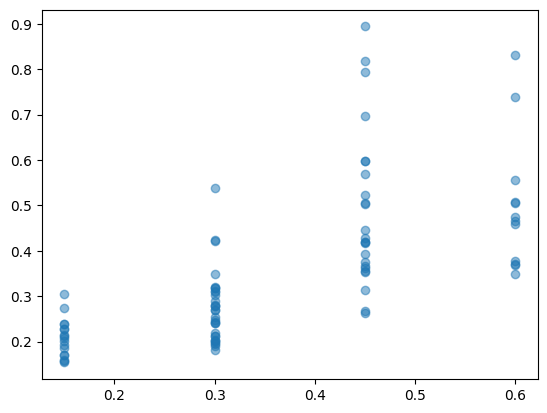

In [13]:
index = 20
plt.scatter(model_out['rt'][index].flatten().detach().cpu().numpy(), 
            data.x[index, :, 1].flatten().detach().cpu().numpy(), alpha=0.5)

/tmp/ipykernel_995209/309057535.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/tmp/ipykernel_995209/309057535.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



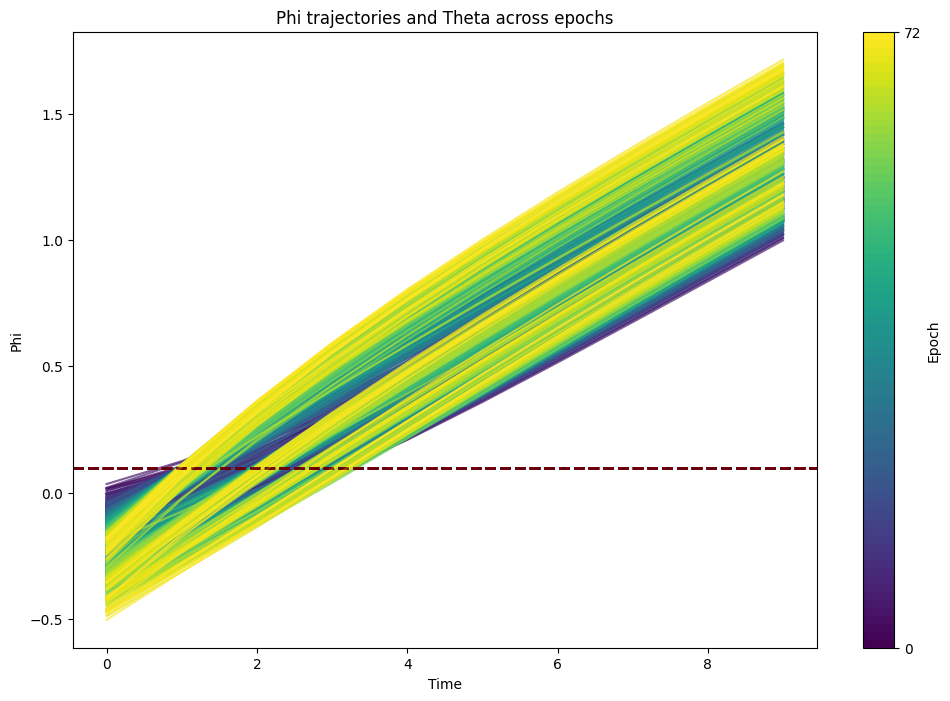

In [51]:
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib as mpl

epochs = np.arange(0, 73)
num_trials = 10

plt.figure(figsize=(12, 8))

blues = cm.get_cmap('viridis', len(epochs) + 5)
reds = cm.get_cmap('Reds', len(epochs) + 5)
norm = Normalize(vmin=epochs.min(), vmax=epochs.max())

for idx, epoch in enumerate(epochs):
    rtrnn_trainer.load_checkpoint(rtrnn_trainer.check_path / f"checkpoint{epoch}.pth")
    model_out = rtrnn_trainer.model(data.u.float(), slow_only=0)
    trial_inds = np.random.choice(model_out['phi'].shape[1], num_trials, replace=False)
    color = blues(norm(epoch))
    for i in trial_inds:
        plt.plot(
            model_out['phi'][0, i].flatten().detach().cpu().numpy(),
            color=color,
            alpha=0.7
        )
    theta_val = rtrnn_trainer.model.theta.item()
    plt.axhline(
        theta_val,
        color=reds(norm(epoch)),
        linestyle='--',
        linewidth=2,
        alpha=0.7
    )

plt.xlabel('Time')
plt.ylabel('Phi')
plt.title('Phi trajectories and Theta across epochs')

sm = mpl.cm.ScalarMappable(cmap=blues, norm=norm)
sm.set_array([])
ax = plt.gca()
cbar = plt.colorbar(sm, ticks=[epochs.min(), epochs.max()], ax=ax)
cbar.set_label('Epoch')

plt.show()